In [1]:
from tqdm import tqdm
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import hdbscan 
import seaborn as sns

# Clustering EncoderMap 

In this notebook, the EncoderMap embedding obtained in [3_EncoderMap_full_length_FAT10.ipynb](./3_EncoderMap_full_length_FAT10.ipynb) is clustered using [HDBSCAN (Hierarchical density based clustering for applications with noise)](https://hdbscan.readthedocs.io/en/latest/index.html#). 
 
The resulting clusters are analyzed by projecting them into the map that is colored by different structural descriptors of FAT10 and by calculating the mean closeness centralities for the clusters.  

Exemplar structures and centroids for the clusters are selected and saved.  


## Loading EncoderMap coordinates
Because EncoderMap is non-deterministic, different runs can lead to deviations in the clustering, such as different cluster numberings. 
To ensure consistency with the analysis in the publication, the EncoderMap coordinates used there are provided here. The clustering is done with these coordinates.

In [2]:
low_d_projection = np.load("./EncoderMap_low_d_coordinates_full_length_FAT10.npy")

## HDBSCAN Clustering 
The parameters were selected to give a more detailed clustering, showing several distinct residue interaction states.

For details on the HDBSCAN parameters, please refer to https://hdbscan.readthedocs.io/en/latest/parameter_selection.html. 

In [3]:
clusterer        = hdbscan.HDBSCAN(min_cluster_size = 100, 
                                   min_samples = 1200, 
                                   cluster_selection_method='leaf')
clusterer.fit(low_d_projection)
cluster_ids           = clusterer.labels_

### Custom colormap

In [4]:
KN_colors = [matplotlib.colors.hex2color(hexcolor) for hexcolor in [
    '#9AA0A7',
    '#008ECE',
    '#3E5496',
    '#0A9086',
    '#A6E1F4',
    '#0AA398', 
    '#398D9F',
    '#00A9E0',
    '#85D1CC', 
    '#9CC6CF',
    '#59C7EB', 
    '#B4BCD6',
    '#FEA090',
    '#8E2043'   
]]
KN_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_colormap", KN_colors)

## Plotting the EncoderMap embedding, colored based on cluster ID 
Grey color represents cluster_id '-1', which means HDBSCAN classifies these points as noise.

Otherwise, the cluster numbering is not inherently meaningful.

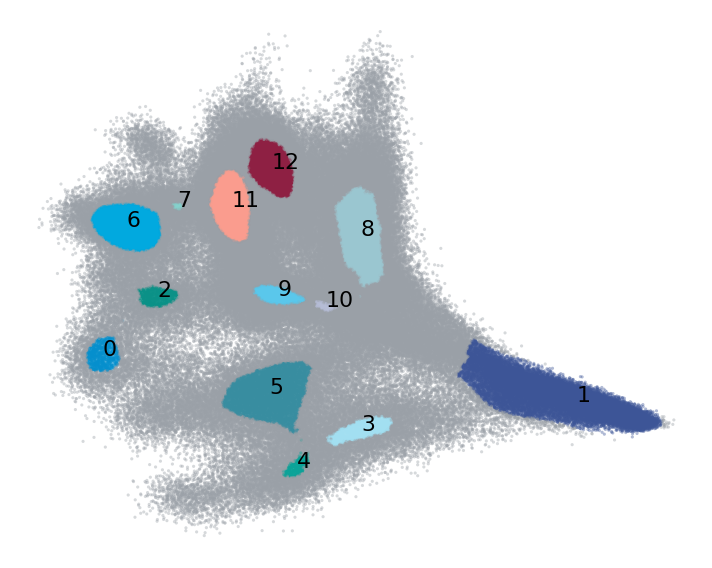

In [8]:
%matplotlib inline
#Plotting points colored based on cluster_id
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
ax.scatter(low_d_projection[:, 0], 
           low_d_projection[:, 1],
           s=10, 
           marker="o", 
           linewidths=0, 
           alpha = 0.4,
           c = cluster_ids, 
           cmap = KN_cmap)

# labeling the cluster by cluster_id
for cluster in np.unique(cluster_ids): 
    if cluster > -1:
        cluster_center_x = np.mean(low_d_projection[np.where(cluster_ids == cluster), 0])
        cluster_center_y = np.mean(low_d_projection[np.where(cluster_ids == cluster), 1])
        ax.text(cluster_center_x, cluster_center_y, cluster, size = 22, color = "k" )
ax.set_axis_off()

## Loading closeness centralities 

calculated in [Calculating_Closeness_Centralities_full_length_FAT10.ipynb]('Calculating_Closeness_Centralities_full_length_FAT10.ipynb')

In [10]:
closeness = np.load("./Closeness_Centralities_full_length_FAT10.npy")

## Plotting the mean closeness centralities for clusters 1,11 and 12

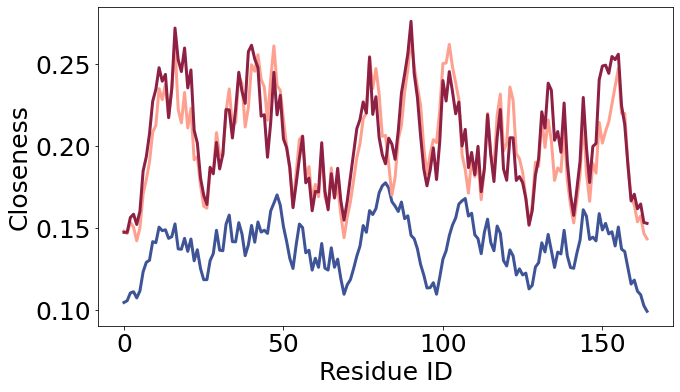

In [13]:
%matplotlib inline
plt.rcParams.update({'font.size': 25}) 
fig, ax = plt.subplots(figsize = (10,6),tight_layout = True) 
plt.ylabel('Closeness') 
plt.xlabel('Residue ID') 
for ID, cluster in enumerate([1,11,12]): 
    frames_in_cluster = np.where(cluster_ids == cluster)[0] 
    mean_closeness = np.mean(closeness[frames_in_cluster], axis = 0) 
    std_closeness = np.std(closeness[frames_in_cluster], axis = 0) 
    ax.plot(mean_closeness,
            color = KN_colors[cluster+1],
            label = str(cluster), linewidth = 3) 
    
    ax.ylim =(0.1,0.33)

    #ax.legend(loc = "lower right", ncol =2) 
    ax.grid(False) 

## Loading the trajectory and calculating the radius of gyration (Rg) for FAT10
The Rg serves as a metric for the compactness of the two-domain protein, which gives an indication to what extent the two domains are in contact. 

High Rg indicates few or no contacts between the domains. 
Low Rg values indicate that the two domains have collapsed on top of one another, forming compact, closed conformations.

In [21]:
topology_file = "./start_frame_FAT10.pdb"
traj_file = "./FAT10_123_traj_center_dt100.xtc"

traj = md.load(traj_file, top = topology_file)

Rg =  md.compute_rg(traj)

## Plotting the EncoderMap and coloring based on Rg, overlaid by the outlines of the clusters. 
The hexbin coloring is made according to the average value of the Rg in each hexagonal bin. 

The cluster outlines for the three most populated clusters are created using the first level of a KDE Plot. 

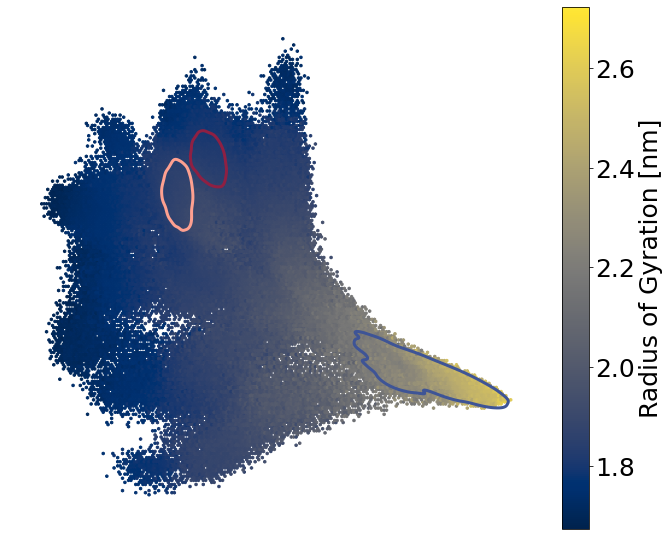

In [28]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    C = Rg,
                    cmap = 'cividis', 
                    mincnt =1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, label = "Radius of Gyration [nm]")
cb.set_alpha(1)
cb.draw_all()

for ID, cluster in enumerate([1,11,12]): 
    if cluster > -1:
        cluster_points = low_d_projection[np.where(cluster_ids == cluster)][::10]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                    y = cluster_points[:,1], 
                    fill = False,
                    levels = 1,
                    color = KN_colors[cluster+1], 
                    linewidths =3)


## Plotting the EncoderMap and coloring based on closeness centrality of Trp17, overlaid by the outlines of the clusters. 
The hexbin coloring is made according to the average closeness centrality for Trp17 across the frames in each hexagonal bin. 

The cluster outlines for the three most populated clusters are created using the first level of a KDE Plot. 

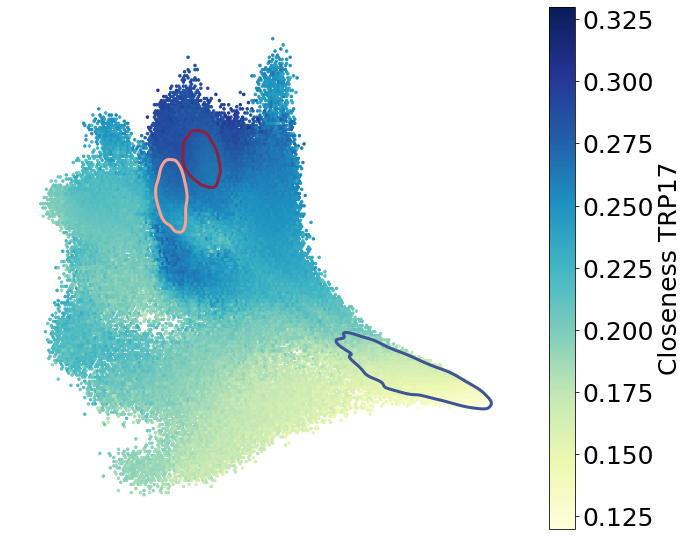

In [29]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    C = closeness[:,16],
                    cmap = 'YlGnBu', 
                    mincnt =1, 
                    vmin = 0.12, 
                    vmax = 0.33,
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, 
                  label = "Closeness TRP17"
                 )
cb.set_alpha(1)
cb.draw_all()

for cluster in [1,11,12]: 
    if cluster > -1:
        cluster_points = low_d_projection[np.where(cluster_ids == cluster)][::50]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                    y = cluster_points[:,1], 
                    fill = False,
                    levels = 1,
                    color = KN_colors[cluster+1], 
                    linewidths =3)
      

## Plotting the EncoderMap and coloring based on closeness centrality of Lys152, overlaid by the outlines of the clusters. 
The hexbin coloring is made according to the average closeness centrality for Lys152 across the frames in each hexagonal bin. 

The cluster outlines for the three most populated clusters are created using the first level of a KDE Plot. 

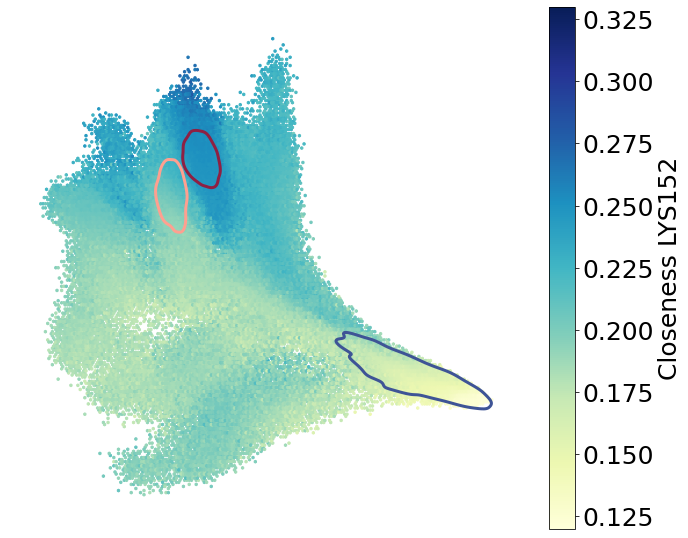

In [30]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    C = closeness[:,151],
                    cmap = 'YlGnBu',
                    vmin = 0.12, 
                    vmax = 0.33,
                    mincnt =1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, 
                  label = "Closeness LYS152"
                 )
cb.set_alpha(1)
cb.draw_all()

for cluster in [1,11,12]: 
    if cluster > -1:
        cluster_points = low_d_projection[np.where(cluster_ids == cluster)][::50]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                    y = cluster_points[:,1], 
                    fill = False,
                    levels = 1,
                    color = KN_colors[cluster+1], 
                    linewidths =3)


## Writing out exemplar structures to represent the clusters
Here the cluster exemplars are selected based on the `clusterer.exemplars_` provided by HDBSCAN. They are points in the embedding that are considered characteristic for the specific cluster. For convex clusters, this will usually coincide with the geometric center of the cluster. For other clusters that have several density wells, there may be several different groups of exemplars. 
From the exemplar frames, every n-th frame is selected to reach the desider number of exemplars. 
The frames are then selected from the trajectory, superposed onto the first frame and saved in .pdb format. 

In [47]:
number_of_representatives = 10
for cluster in tqdm(np.unique(cluster_ids)): 
    if cluster > -1: 
        
        # Select all exemplars (given in xy coordinates) for a cluster
        cluster_exemplars_xy = clusterer.exemplars_[cluster] 
        
        #find frame IDs for xy-coordinates
        cluster_exemplars_id = [np.where((low_d_projection == cluster_exemplars_xy[point]).all(axis = 1))[0][0] for point in range(len(cluster_exemplars_xy))] 
        
        cluster_size = len(cluster_exemplars_id)
        #if there are too many exemplars, select every n-th exemplar
        if (cluster_size > number_of_representatives): 
            reduction_factor = int(np.ceil(cluster_size/number_of_representatives))
            cluster_representatives = cluster_exemplars_id[::reduction_factor]
        else: 
            cluster_representatives = cluster_exemplars_id
        #save molecular structures of the exemplars as .pdb 
        cluster_representatives_structures = traj[cluster_representatives].superpose(reference=traj[cluster_representatives[0]])
        cluster_representatives_structures.save_pdb("./Cluster_Exemplars_EncoderMap/Cluster_Exemplars_Cluster_{}.pdb".format(cluster))

100%|██████████| 14/14 [00:13<00:00,  1.08it/s]


## Writing out a single centroid structure to represent each cluster
Sometimes it can be necessary to have one single structure for a cluster that should be as representative of the other cluster members as possible.

Here, we select such a "centroid structure" from the exemplars `clusterer.exemplars_` by choosing the frame that has the least closeness centrality difference to all other exemlars.
This ensures that the centroid is characteristic for the cluster and reduces the computational effort for the pairwise comparison for the closeness centrality distances. 
The centroid selection follows the procedure described by mdtraj [here](https://mdtraj.org/1.9.3/examples/centroids.html). 

The centroid frames are then selected from the trajectory and saved in .pdb format. 

In [48]:
centroid_indices = []
for cluster in tqdm(np.unique(cluster_ids)): 
    if cluster > -1: 
        
        # Select all exemplars (given in xy coordinates) for a cluster
        cluster_exemplars_xy = clusterer.exemplars_[cluster]
        
        #find frame IDs for xy-coordinates
        cluster_exemplars_id = [np.where((low_d_projection == cluster_exemplars_xy[point]).all(axis = 1))[0][0] for point in range(len(cluster_exemplars_xy))]
        
        closeness_in_cluster = closeness[cluster_exemplars_id]
        cluster_size = len(cluster_exemplars_id)
        distances = np.empty((cluster_size,cluster_size))
        
        #calculate pairwise distances between exemplars in closeness centrality space 
        for i in range(cluster_size):
            for j in range(cluster_size): 
                distances[i,j] = np.linalg.norm(closeness_in_cluster[i]-closeness_in_cluster[j])
        beta = 1
        
        #find centroid exemplar with smallest distance to all other exemplars 
        index_in_exemplar_list = np.exp(-beta*distances / distances.std()).sum(axis=1).argmax()
        
        #find the centroid frame in the full data set
        index_in_full_dataset = cluster_exemplars_id[index_in_exemplar_list]
        centroid_indices.append(index_in_full_dataset)
        
        #save centroid frame
        cluster_centroid_structure = traj[index_in_full_dataset]
        cluster_centroid_structure.save_pdb("./Cluster_Centroids_EncoderMap/Cluster_Centroid_Cluster_{}.pdb".format(cluster))


100%|██████████| 14/14 [00:07<00:00,  1.82it/s]


## Plotting EncoderMap and HDBSCAN Clusters together with exemplars (black) and centroids (red)

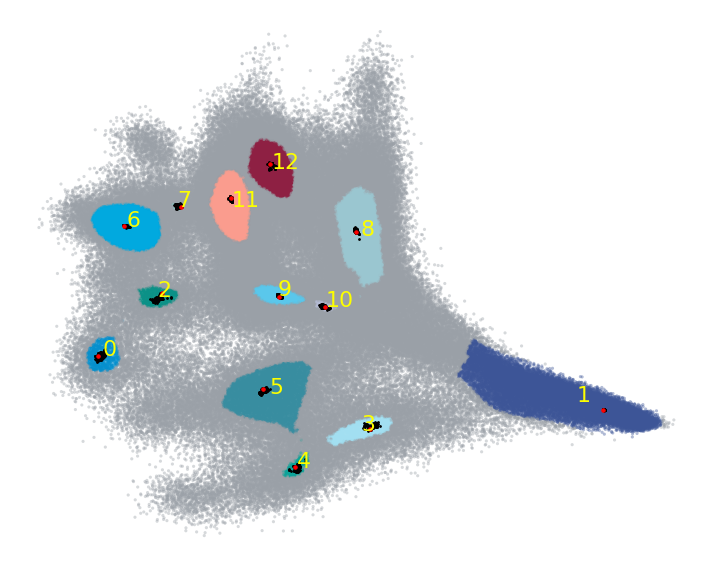

In [52]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)

# Plot EncoderMap colored by cluster_id   
ax.scatter(low_d_projection[:, 0], 
           low_d_projection[:, 1],
           s=10, 
           marker="o", 
           linewidths=0, 
           alpha = 0.4,
           c = cluster_ids, 
           cmap = KN_cmap)

# Label clusters based on cluster_id
for cluster in np.unique(cluster_ids): 
    if cluster > -1:
        cluster_center_x = np.mean(low_d_projection[np.where(cluster_ids == cluster), 0])
        cluster_center_y = np.mean(low_d_projection[np.where(cluster_ids == cluster), 1])
        ax.text(cluster_center_x, cluster_center_y, cluster, size = 22, color = "#FDFF00" )
ax.set_axis_off()

#Plot cluster exemplars (black)
for cluster in np.unique(cluster_ids):   
    if (cluster > -1): 
        cluster_exemplars_xy = clusterer.exemplars_[cluster]
        plt.scatter(cluster_exemplars_xy[:,0],
                    cluster_exemplars_xy[:,1],
                    color = 'k', 
                    marker = 'o', 
                    s = 3)
#Plot closeness centroids of exemplars (red)
for cluster in np.unique(cluster_ids):
    if (cluster > -1):
        cluster_centroid_id = centroid_indices[cluster]
        plt.scatter(low_d_projection[cluster_centroid_id,0], 
                    low_d_projection[cluster_centroid_id,1], 
                    color = 'red', 
                    marker = 'o', 
                    s = 12)

## Coloring the EncoderMap based on specific contacts

To color the EncoderMap based on the probability of a contact between a pair of residues, we can define a custom coloring function (`reduce_C_function`) for the hexbin plot from matplotlib. 
This custom function takes the adjacency matrix entries for a residue pair and forms the mean across all frames, effectively calculating the probability of the contact for each hexagonal bin.
Please refer to the [documentation of `matplotlib.pyplot.hexbin`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hexbin.html) for more information on the custom coloring function. 

### This code only works if an `adjacency_matrices` array is provided! 
The adjacency matrices here are loaded from disk using memory mapping in this notebook. Due to storage constraints, the adjacency matrix file is not not provided here. It was calculated in the same manner as in  [1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb](1_Calculating_Closeness_Centralities_full_length_FAT10.ipynb) and can be written out when running the closeness centrality calculation if needed. 

In [53]:
adjacency_matrices = np.load("/home/leonf/phd/Analysis_FAT10_Simulation_Triplicates/FAT10_123_adjacency_matrices_sidechain_distances_00_45_dt100_connected_bb.npy",
                             mmap_mode = 'r')
def reduce_C_function(contact):
    return(np.mean(contact,axis = 0))

In [57]:
adjacency_matrices.shape

(300150, 165, 165)

## Defining the contact pair: Trp17 and Lys 152 

In [54]:
contact = adjacency_matrices[:,16,151] #Residues are 0-Indexed

### Custom colormap

In [55]:
seeblau_and_white = [(1, 1, 1), matplotlib.colors.hex2color("#008ECE")] 
cmap_name = 'seeblau2white'
seeblau2white = matplotlib.colors.LinearSegmentedColormap.from_list(cmap_name, seeblau_and_white, N=100)

## Plot probability of contact between Trp17-Lys152 for each hexagonal bin

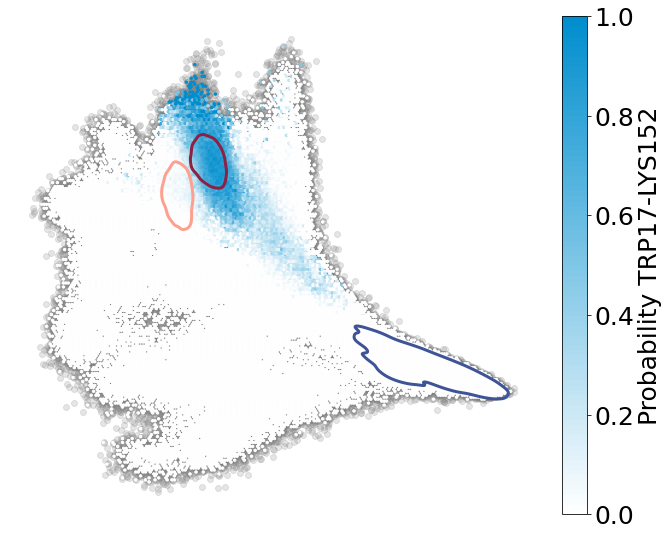

In [56]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
#plot the points in light gray to make the outline of the map visible
ax.scatter(low_d_projection[:, 0], 
           low_d_projection[:, 1], 
            color='gray', 
            alpha = 0.2)
# plot probabilities of contact 
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    C = contact,                          # input for the custom coloring function
                    reduce_C_function=reduce_C_function,  # custom coloring function, defined above 
                    cmap = seeblau2white, 
                    mincnt =1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, label = "Probability TRP17-LYS152")
cb.set_alpha(1)
cb.draw_all()

#overlay the most populated clusters 
for ID, cluster in enumerate([1,11,12]): 
    if cluster > -1:
        cluster_points = low_d_projection[np.where(cluster_ids == cluster)][::10]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                              y = cluster_points[:,1], 
                              fill = False,
                              levels = 1,
                              color = KN_colors[cluster+1], 
                              linewidths =3)

## Plot probability of contact between Ser84-Glu87 for each hexagonal bin

## Defining the contact pair: Ser84-Glu87

In [36]:
contact = adjacency_matrices[:,83,86] # Residues are 0-Indexed

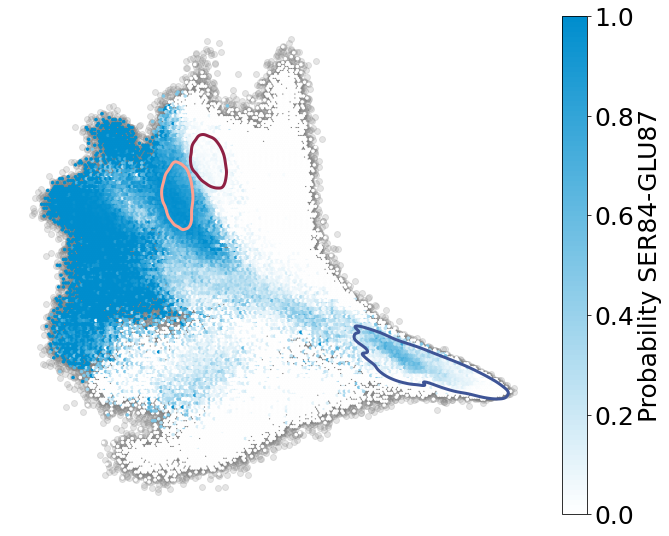

In [39]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(figsize = (10,8),tight_layout = True)
#plot the points in light gray to make the outline of the map visible
ax.scatter(low_d_projection[:, 0], 
           low_d_projection[:, 1], 
            color='gray', 
            alpha = 0.2)
# plot probabilities of contact 
hex_map = ax.hexbin(low_d_projection[:, 0], 
                    low_d_projection[:, 1],
                    C = contact,                         # input for the custom coloring function
                    reduce_C_function=reduce_C_function, # custom coloring function, defined above
                    cmap = seeblau2white, 
                    mincnt =1, 
                    gridsize = 200)
ax.set_axis_off()
cb = plt.colorbar(hex_map, label = "Probability SER84-GLU87")
cb.set_alpha(1)
cb.draw_all()

for ID, cluster in enumerate([1,11,12]): 
    if cluster > -1:
        cluster_points = low_d_projection[np.where(cluster_ids == cluster)][::10]
        kdeplot = sns.kdeplot(x = cluster_points[:,0], 
                              y = cluster_points[:,1], 
                              fill = False,
                              levels = 1,
                              color =KN_colors[cluster+1], 
                              linewidths =3)